In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pickle
from agent_replay import Agent 
from utils import plot_maze, load_env

In [2]:
env_file_path  = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/mazes/tolman1.txt'
env_config     = load_env(env_file_path)

# --- Specify agent parameters ---
ag_config = {
    'alpha'          : 1,          # online learning rate
    'alpha_r'        : 1,          # offline learning rate
    'online_beta'    : 2,         # inverse temperature
    'gain_beta'      : 50,
    'need_beta'      : 60,
    'policy_type'    : 'softmax',
    'gamma'          : 0.85,       # discount
    'horizon'        : 2,          # minus 1
    'xi'             : 1e-9,       # EVB threshold
    'num_sims'       : 2000,       # number of MC simulations

    'phi'            : 0.5,
    'kappa'          : 0.5,
}

agent = Agent(*[ag_config, env_config])

In [3]:
Q_MB  = agent._solve_mb(1e-5)

### Example replays

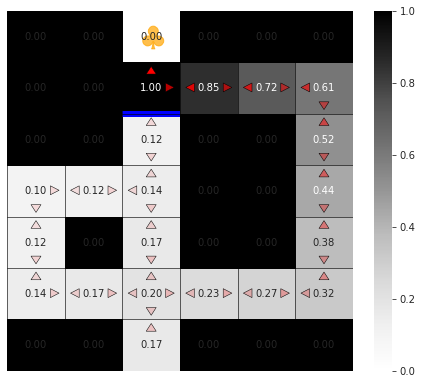

In [4]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, Q_MB, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/q_mb.svg', transparent=True)

In [5]:
agent.state = 38          # start state
agent.Q     = Q_MB.copy() # set MF Q values
agent.M     = 0.5         # completely uncertain
Q_history, gain_history, need_history = agent._replay()

Replay [<14, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.42, evb: 0.00001
Replay [<20, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.36, evb: 0.00005
Replay [<26, 0>, 0] horizon 0, q_old: 0.12, q_new: 0.31, evb: 0.00521
Replay [<32, 0>, 0] horizon 0, q_old: 0.14, q_new: 0.26, evb: 0.11620
Replay [<31, 0>, 3] horizon 0, q_old: 0.17, q_new: 0.22, evb: 0.00001


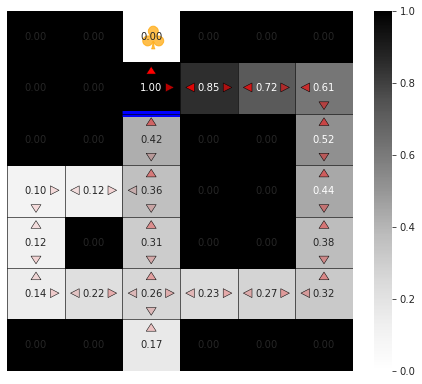

In [6]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/replay_before.svg', transparent=True)

In [7]:
Q        = agent.Q.copy()
Q[14, 0] = 0
agent.Q  = Q

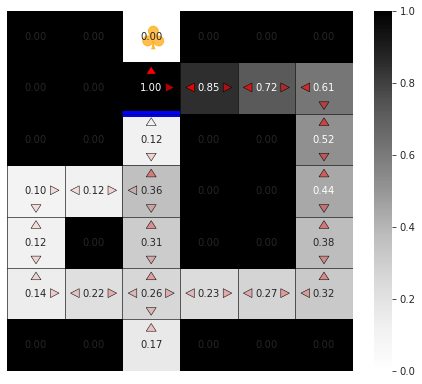

In [8]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/online.svg', transparent=True)

In [9]:
agent.state = 14
agent.M     = 0.0
Q_history, gain_history, need_history = agent._replay()

Replay [<20, 0>, 0] horizon 0, q_old: 0.36, q_new: 0.10, evb: 0.04065
Replay [<20, 0>, 1] horizon 0, q_old: 0.14, q_new: 0.26, evb: 0.04447
Replay [<14, 0>, 1] horizon 0, q_old: 0.12, q_new: 0.22, evb: 0.00134
Replay [<19, 0>, 3] horizon 0, q_old: 0.12, q_new: 0.22, evb: 0.00002


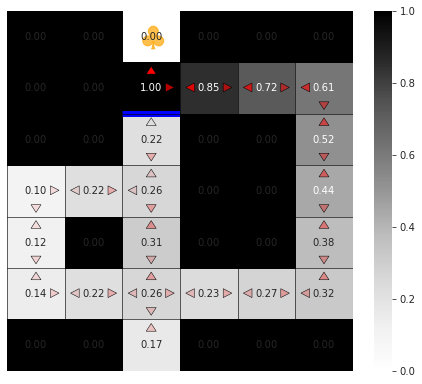

In [10]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, agent.Q, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/replay_after.svg', transparent=True)

### Exploration probability

In [25]:
np.random.seed(0)

agent.state  = 38 # start state
M_range      = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
qs           = []

for M in M_range:
    agent.Q  = Q_MB.copy()
    agent.M  = M
    
    _, _, _  = agent._replay()
    
    Q_after  = agent.Q.copy()
    
    qs      += [Q_after[14, :].copy(), Q_after[20, :].copy(), Q_after[26, :].copy(), Q_after[32, :].copy()]

Replay [<14, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.17, evb: 0.00000
Replay [<20, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.14, evb: 0.00001
Replay [<14, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.34, evb: 0.00004
Replay [<20, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.29, evb: 0.00007
Replay [<26, 0>, 0] horizon 0, q_old: 0.12, q_new: 0.25, evb: 0.00273
Replay [<32, 0>, 0] horizon 0, q_old: 0.14, q_new: 0.21, evb: 0.01790
Replay [<31, 0>, 3] horizon 0, q_old: 0.17, q_new: 0.18, evb: 0.00003
Replay [<30, 0>, 3] horizon 0, q_old: 0.14, q_new: 0.15, evb: 0.00000
Replay [<14, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.42, evb: 0.00001
Replay [<20, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.36, evb: 0.00074
Replay [<26, 0>, 0] horizon 0, q_old: 0.12, q_new: 0.31, evb: 0.00570
Replay [<32, 0>, 0] horizon 0, q_old: 0.14, q_new: 0.26, evb: 0.11108
Replay [<31, 0>, 3] horizon 0, q_old: 0.17, q_new: 0.22, evb: 0.00002
Replay [<14, 0>, 0] horizon 0, q_old: 0.10, q_new: 0.51, evb: 0.00006
Replay [<20, 0>, 0] 

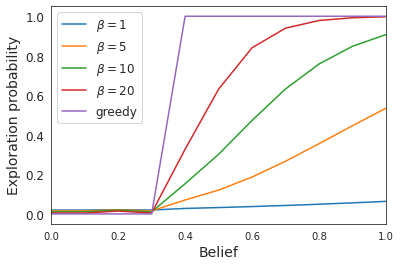

In [29]:
betas = [1, 5, 10, 20]
for beta in betas:

    agent.online_beta = beta
    probs = np.zeros(len(M_range))
    for i in range(0, len(qs), 4):
        probs[i//4] = agent._policy(qs[i])[0]*agent._policy(qs[i+1])[0]*agent._policy(qs[i+2])[0]*agent._policy(qs[i+3])[0]
    plt.plot(np.array(M_range), probs, label=r'$\beta=%u$'%beta)

probs = np.zeros(len(M_range))
for i in range(0, len(qs), 4):
    probs[i//4] = (qs[i][0] == np.nanmax(qs[i]))*(qs[i+1][0] == np.nanmax(qs[i+1]))*(qs[i+2][0] == np.nanmax(qs[i+2]))*(qs[i+3][0] == np.nanmax(qs[i+3]))
plt.plot(np.array(M_range), probs, label='greedy')

plt.ylim(-0.05, 1.05)
plt.xlim(0, 1)
# plt.xticks(np.linspace(0, 1, 11), np.linspace(0, 1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Belief', fontsize=14)
plt.ylabel('Exploration probability', fontsize=14)
plt.legend(prop={'size':12})
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/explore_proba.svg', transparent=True)